In [6]:
# import os
# import shutil
# import random

# # Path to the main directory containing train_dir and val_dir
# main_directory = 'base_dir'

# # Create test_dir directory if it doesn't exist
# test_dir = os.path.join(main_directory, 'test_dir')
# if not os.path.exists(test_dir):
#     os.mkdir(test_dir)

# # List of classes
# classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# # Percentage of images to move from train_dir to test_dir
# percentage_to_move = 0.15

# # Loop through each class and move images
# for class_name in classes:
#     train_class_dir = os.path.join(main_directory, 'train_dir', class_name)
#     test_class_dir = os.path.join(test_dir, class_name)

#     if not os.path.exists(test_class_dir):
#         os.mkdir(test_class_dir)

#     # Get the list of images in the train class directory
#     images = os.listdir(train_class_dir)

#     # Calculate the number of images to move to test_dir
#     num_images_to_move = int(len(images) * percentage_to_move)

#     # Randomly select images to move
#     images_to_move = random.sample(images, num_images_to_move)

#     # Move selected images to test_dir
#     for image_name in images_to_move:
#         src_path = os.path.join(train_class_dir, image_name)
#         dest_path = os.path.join(test_class_dir, image_name)
#         shutil.move(src_path, dest_path)

# print("Images moved from train_dir to test_dir successfully!")

Images moved from train_dir to test_dir successfully!


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Set GPU memory growth configuration before importing TensorFlow
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in physical_gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Data directories and parameters
train_data_dir = 'base_dir/train_dir'
validation_data_dir = 'base_dir/val_dir'
img_width, img_height = 224, 224
batch_size = 16

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Load the pre-trained DenseNet-121 model (weights pre-trained on ImageNet)
base_model = DenseNet121(weights='imagenet', include_top=False)

# Freeze some layers in the base model
num_layers_to_freeze = 95  # Choose the number of layers you want to freeze
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Add BatchNormalization layer for better convergence
predictions = Dense(7, activation='softmax')(x)

# Create the final model
model_dense = Model(inputs=base_model.input, outputs=predictions)

# Learning Rate Scheduler
initial_learning_rate = 0.0005
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=10000,   # Adjust decay_steps 
#     decay_rate=0.9       # Adjust decay_rate 
# )
# lr_value = lr_schedule(0)
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

model_dense.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Fit the model using your data generators
epochs = 60
history = model_dense.fit(
    train_generator,
    epochs=epochs,
    verbose=1,
    steps_per_epoch=train_generator.samples // batch_size,
    callbacks=[learning_rate_reduction, early_stopping],
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Found 32786 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Epoch 1/60
2049/2049 [==============================] - 296s 135ms/step - loss: 1.1015 - accuracy: 0.7340 - val_loss: 0.4692 - val_accuracy: 0.8836 - lr: 0.0010
Epoch 2/60
2049/2049 [==============================] - 280s 136ms/step - loss: 0.5408 - accuracy: 0.8255 - val_loss: 0.5209 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 3/60
2049/2049 [==============================] - 284s 138ms/step - loss: 0.4216 - accuracy: 0.8656 - val_loss: 0.4764 - val_accuracy: 0.8761 - lr: 0.0010
Epoch 4/60
2049/2049 [==============================] - ETA: 0s - loss: 0.3412 - accuracy: 0.8945
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2049/2049 [==============================] - 285s 139ms/step - loss: 0.3412 - accuracy: 0.8945 - val_loss: 7.4979 - val_accuracy: 0.0506 - lr: 0.0010
Epoch 5/60
2049/2049 [==============================] - 285s 139ms/step - loss: 0.1789 - accuracy: 0.9438 - v

In [3]:
# Save the trained model
model_dense.save("skin_cancer_dense_model_accuracy99.91.h5")

# Optionally, you can also save the model's architecture in JSON format
model_architecture = model_dense.to_json()
with open("skin_cancer_dense_architecture_accuracy99.95.json", "w") as json_file:
    json_file.write(model_architecture)

In [6]:
pip install sklearn

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for sklearn: filename=sklearn-0.0.post7-py3-none-any.whl size=2956 sha256=d76f9fe3a2caad791f4f9845b80bb8d4e49f334c32e97756f719cb0b8b5265af
  Stored in directory: c:\users\shubh\appdata\local\pip\cache\wheels\f3\6d\ba\d999da6dff3d5cc6735e9855579fa236bf7c5bdbb210a873b8
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/2d/30/3afb8bcb785653254eb646ff2680ec4d637b40b06f4b046aca17b5e086b0/scikit_learn-1.3.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.3 MB 330.3 kB/s eta 0:00:29
   ---------------------------------------- 0.0/9.3 MB 245.8 kB/s eta 0:00:38

In [16]:
import numpy as np
from sklearn.metrics import classification_report

# Load your test dataset (similar to how you loaded the training data)
test_data_dir = 'base_dir/test_dir'
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Keep the order of images for evaluation
)

# Make predictions using the model
predictions = model_dense.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions and true labels to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Generate a classification report
class_names = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_names)

print(report)

Found 5783 images belonging to 7 classes.
362/362 [==============================] - 24s 61ms/step
              precision    recall  f1-score   support

       akiec       0.91      0.98      0.94       782
         bcc       0.93      0.99      0.96       878
         bkl       0.82      0.91      0.86       888
          df       1.00      1.00      1.00       661
         mel       0.99      0.68      0.81       888
          nv       0.88      0.96      0.92       893
        vasc       1.00      0.99      1.00       793

    accuracy                           0.93      5783
   macro avg       0.93      0.93      0.93      5783
weighted avg       0.93      0.93      0.92      5783



In [11]:
pip install matplotlib


  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/c9/46/6cbaf20f5bd0e7c1d204b45b853c2cd317b303fada90245f2825ecca47de/matplotlib-3.7.2-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/a5/d6/80258c2759bd34abe267b5d3bc6300f7105aa70181b99d531283f7e7c79e/contourpy-1.1.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/cd/b1/8ba85c3d50562438d5991f5698d46b66dcadd43d230c7ba72edbd0c96ce8/fonttools-4.42.0-cp39-cp39-win_amd64.whl.metadata
     ---------------------------------------- 0.0/153.7 kB ? eta -:--:--
     ------- ------------------------------- 30.7/153.7 kB 1.3 MB/s eta 0:00:01
     ----------------- ------------------- 71.7/153.7 kB 787.7 kB/s eta 0:00:01
     ----------------------- --------------- 92.2/153.7 kB 1.1 MB/s eta 0:00:01
     ---------------------------------

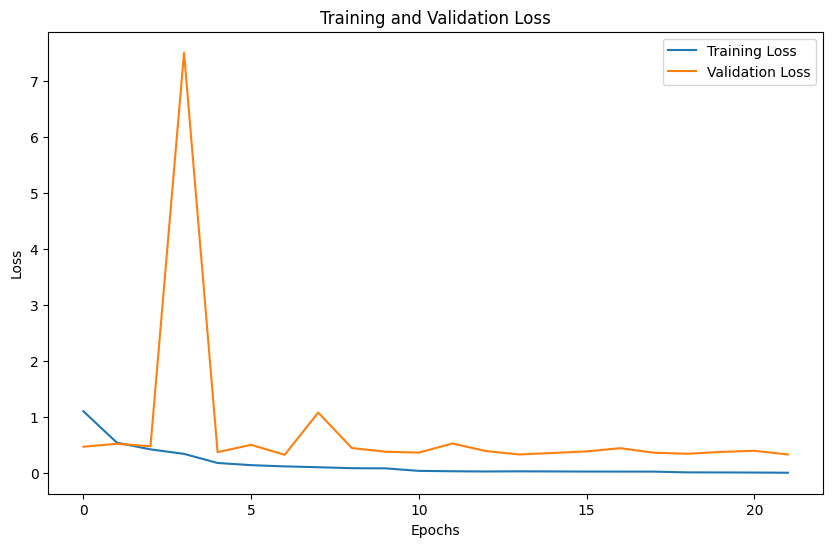

In [12]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

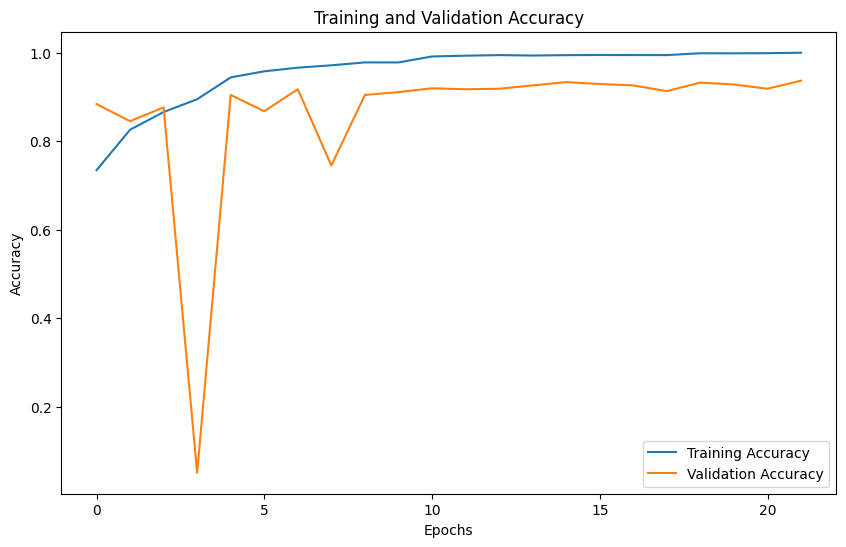

In [13]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [18]:
# Convert the Keras model to a TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model_dense)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open("skin_cancer_dense_model_accuracy99_95or93.tflite", "wb") as tflite_file:
    tflite_file.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\shubh\AppData\Local\Temp\tmpyfdutu24\assets


INFO:tensorflow:Assets written to: C:\Users\shubh\AppData\Local\Temp\tmpyfdutu24\assets


In [20]:
# Convert the Keras model to a quantization-aware TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model_dense)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the quantized TFLite model to a file
with open("skin_cancer_dense_model_quantized_accuracy99_95or93.tflite", "wb") as tflite_file:
    tflite_file.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\shubh\AppData\Local\Temp\tmp90wwaocs\assets


INFO:tensorflow:Assets written to: C:\Users\shubh\AppData\Local\Temp\tmp90wwaocs\assets
